In [5]:
import pandas as pd
import numpy as np
import requests
import json
import os
from pyserini.search import SimpleSearcher
from sklearn.metrics import ndcg_score
import shlex
import subprocess
import sys
import os.path
from os import path


In [ ]:
#%%capture
#!pip install pyjnius
#!java -version
#from jnius import autoclass
#import os
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
#JString = autoclass('java.lang.String')
#JString('Hello world')

#%%capture

#!mkdir -p /usr/lib/jvm/java-1.11.0-openjdk-amd64/jre/lib/amd64/server/
#!ln -s /usr/lib/jvm/java-1.11.0-openjdk-amd64/lib/server/libjvm.so /usr/lib/jvm/java-1.11.0-openjdk-amd64/jre/lib/amd64/server/libjvm.so

In [109]:
#for i in qlist:
#    if not os.path.exists('query_results_lm/'+i):
#        os.makedirs('query_results_lm/'+i)

In [108]:
"""for q in qlist:
    print("now writing results for: " + q)
    req = requests.get("http://api.nordlys.cc/er?q="+q+"&1st_num_docs=1000&model=lm")
    if req.status_code != 200:
    # This means something went wrong.
        raise ApiError('GET /tasks/ {}'.format(req.status_code))
    num_docs = 1000
    idlist = []
    for i in range(num_docs):
        getid = req.json()["results"][str(i)]["entity"]
        idreq = requests.get("http://api.nordlys.cc/ec/lookup_id/"+getid)
        if idreq.status_code != 200:
        # This means something went wrong.
            raise ApiError('GET /tasks/ {}'.format(idreq.status_code))
        dump = idreq.json()
        writing_dict = {}
        writing_dict['id'] = getid
        writing_dict['contents'] = json.dumps(dump)
        dumpdict = json.dumps(writing_dict)
        with open('query_results_lm/'+q+'/'+str(i)+'.json', 'w') as out:
            out.write(dumpdict)
"""

'for q in qlist:\n    print("now writing results for: " + q)\n    req = requests.get("http://api.nordlys.cc/er?q="+q+"&1st_num_docs=1000&model=lm")\n    if req.status_code != 200:\n    # This means something went wrong.\n        raise ApiError(\'GET /tasks/ {}\'.format(req.status_code))\n    num_docs = 1000\n    idlist = []\n    for i in range(num_docs):\n        getid = req.json()["results"][str(i)]["entity"]\n        idreq = requests.get("http://api.nordlys.cc/ec/lookup_id/"+getid)\n        if idreq.status_code != 200:\n        # This means something went wrong.\n            raise ApiError(\'GET /tasks/ {}\'.format(idreq.status_code))\n        dump = idreq.json()\n        writing_dict = {}\n        writing_dict[\'id\'] = getid\n        writing_dict[\'contents\'] = json.dumps(dump)\n        dumpdict = json.dumps(writing_dict)\n        with open(\'query_results_lm/\'+q+\'/\'+str(i)+\'.json\', \'w\') as out:\n            out.write(dumpdict)\n'

In [ ]:
"""
searcher = SimpleSearcher('test_query_results_lm/indexes_foodblog/')
searcher.set_rm3(10, 10, 0.5)
hits = searcher.search('hubble space telescope')


df = pd.DataFrame(columns=['queryID','documentID','rank', 'score']) 

queryid = "INEX_LD-20120122"

# Print the first 10 hits:
for i in range(0, 10):
    docid = hits[i].docid
    rank = i+1
    score = hits[i].score
    df = df.append({'queryID': queryid, 'documentID' : docid, 'rank' : rank, 'score' : score}, ignore_index=True)

qrels =  pd.read_csv('qrels-v2.txt', sep="\t", header=None)
qrels.columns = ["queryID", "Q0", "documentID", "relevance_assesment"]
qrels = qrels.drop('Q0', axis=1)

query_ids = df.queryID.unique()

for q in query_ids:
    df_selection = df[df['queryID'] ==q]
    qrels_selection = qrels[qrels['queryID'] == q]
    qrels_selection = qrels_selection.drop('queryID', axis=1)
    
    true_label = qrels_selection['relevance_assesment'].sort_values(ascending=False) #, na_position='last'

    result = pd.merge(df_selection, qrels_selection, on='documentID', how='left')
    result['relevance_assesment'] = result['relevance_assesment'].fillna(0)

# we predict some scores (relevance) for the answers
list1 = result['relevance_assesment'].astype(int).tolist()
scores = np.asarray([list1])

# we have groud-truth relevance of some answers to a query:
top_results = true_label[0:len(scores[0])].astype(int).tolist()
true_relevance = np.asarray([top_results])


print(true_relevance)
print(scores)
ndcg_score(true_relevance, scores)
"""

In [121]:
def calculate_score(fn_qrels='qrels-v2.txt', prediction="test_foodblog.txt"):
    cmd = "trec_eval.9.0.4/trec_eval {judgement} {output} -m map -m recip_rank".format(output=prediction, judgement=fn_qrels)
    pargs = shlex.split(cmd)
    p = subprocess.Popen(pargs, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    pout, perr = p.communicate()
  #  print("running {}".format(cmd))
    if sys.version_info[0] < 3:
        lines = pout.split('\n')
    else:
        lines = pout.split(b'\n')
    MAP = float(lines[0].strip().split()[-1])
    MRR = float(lines[1].strip().split()[-1])
 #   print("MAP: {}".format(MAP))
 #   print("MRR: {}".format(MRR))
    return MAP, MRR

In [54]:
queryfile = "./queries-v2.txt"
qlist = []
idlist = []

with open(queryfile, 'r') as f:
    for line in f:
        sep = line.split("\t")
        query = sep[1]
        idlist.append(sep[0])
        query = query.rstrip("\n")
        #adding plus sign instead of space to append to queries
        query = query.replace(" ", "+")        
        qlist.append(query)
print('total lenght queries: ', len(qlist))

for i, q in enumerate(qlist):
    queryid = idlist[i]
    if not path.exists(f'query_results_update/{q}/'):
        print('query data is missing: ', f'query_results_update/{q}/')

dupes = [x for n, x in enumerate(qlist) if x in qlist[:n]]
print('duplicates in querys: ', dupes) # [[1], [3]]


total lenght queries:  467


In [88]:
df = pd.DataFrame(columns=['queryID', 'Q0', 'documentID','rank', 'score', 'model']) 
q0 = "Q0"
rm3 = 'lm'

for i, q in enumerate(qlist):
    queryid = idlist[i]
    #print('query: ', f'index_query_results_lm/query_results_lm/{q}/')
    if path.exists(f'index_query_results_lm/query_results_lm/{q}/'):
        link = f'index_query_results_lm/query_results_lm/{q}/'
        searcher = SimpleSearcher(link)
        hits = searcher.search(q, 100)
        for i in range(0, len(hits)):
            docid = hits[i].docid
            rank = i+1
            score = hits[i].score
            df = df.append({'queryID': queryid, 'Q0': q0, 'documentID' : docid, 'rank' : rank, 'score' : score, 'model': rm3}, ignore_index=True)
            
df.to_csv(r'lm_results.txt', header=None, index=None, sep=' ', mode='a')

In [86]:
df = pd.DataFrame(columns=['queryID', 'Q0', 'documentID','rank', 'score', 'model']) 
q0 = "Q0"
rm3 = 'bm25'

for i, q in enumerate(qlist):
    queryid = idlist[i]
    #print('query: ', f'index_query_results_lm/query_results_lm/{q}/')
    if path.exists(f'query_results_update/{q}/'):
        link = f'query_results_update/{q}/'
        searcher = SimpleSearcher(link)
        searcher.set_bm25(1.2, 0.8)
        hits = searcher.search(q, 100)
        for i in range(0, len(hits)):
            docid = hits[i].docid
            rank = i+1
            score = hits[i].score
            df = df.append({'queryID': queryid, 'Q0': q0, 'documentID' : docid, 'rank' : rank, 'score' : score, 'model': rm3}, ignore_index=True)
            
df.to_csv(r'bm25_results.txt', header=None, index=None, sep=' ', mode='a')

In [87]:
df = pd.DataFrame(columns=['queryID', 'Q0', 'documentID','rank', 'score', 'model']) 
q0 = "Q0"
rm3 = 'rm3'

for i, q in enumerate(qlist):
    queryid = idlist[i]
    #print('query: ', f'index_query_results_lm/query_results_lm/{q}/')
    if path.exists(f'query_results_update/{q}/'):
        link = f'query_results_update/{q}/'
        searcher = SimpleSearcher(link)
        searcher.set_rm3(10, 10, 0.5)
        hits = searcher.search(q, 100)
        for i in range(0, len(hits)):
            docid = hits[i].docid
            rank = i+1
            score = hits[i].score
            df = df.append({'queryID': queryid, 'Q0': q0, 'documentID' : docid, 'rank' : rank, 'score' : score, 'model': rm3}, ignore_index=True)
            
df.to_csv(r'rm3_results.txt', header=None, index=None, sep=' ', mode='a')


In [203]:
df_results = pd.DataFrame(columns=['MAP', 'MMR', 'type'])

MAP, MMR = calculate_score(prediction = 'lm_results.txt')
df_results = df_results.append({'MAP': MAP, 'MMR': MMR, 'type':'lm'}, ignore_index=True)
MAP, MMR = calculate_score(prediction = 'bm25_results.txt')
df_results = df_results.append({'MAP': MAP, 'MMR': MMR, 'type':'bm25'}, ignore_index=True)
MAP, MMR = calculate_score(prediction = 'rm3_results.txt')
df_results = df_results.append({'MAP': MAP, 'MMR': MMR, 'type':'lm+rm3'}, ignore_index=True)

print(df_results)

      MAP     MMR    type
0  0.2018  0.5075      lm
1  0.1763  0.4657    bm25
2  0.1384  0.3867  lm+rm3


In [143]:
def get_results_per_category(file, method):
    df = pd.read_csv(file, sep=' ')
    df.columns = ['queryID', 'Q0', 'documentID','rank', 'score', 'model']

    semsearch = df[df['queryID'].str.contains("SemSearch_ES")]
    inex_ld = df[df['queryID'].str.contains("INEX")]
    listsearch = df[df['queryID'].str.contains("TREC|SemSearch_LS|INEX_XER")]
    quald = df[df['queryID'].str.contains("QALD2")]

   # print('SemSearch should be 113 :', len(np.unique(semsearch['queryID'])))
   # print('INEX-LD should be 99 :', len(np.unique(inex_ld['queryID'])))
   # print('ListSearch should be 115 :', len(np.unique(listsearch['queryID'])))
   # print('QALD-2 should be 140 :', len(np.unique(quald['queryID'])))

    semsearch.to_csv(f'{method}_Semsearch_results.txt', header=None, index=None, sep=' ')
    inex_ld.to_csv(f'{method}_INEx_LD_results.txt', header=None, index=None, sep=' ')
    listsearch.to_csv(f'{method}_ListSearch_results.txt', header=None, index=None, sep=' ')
    quald.to_csv(f'{method}_quald_results.txt', header=None, index=None, sep=' ')

    df_output = pd.DataFrame(columns=[f'MAP_{method}', f'MMR_{method}', 'type'])

    MAP, MMR = calculate_score(prediction = f'{method}_Semsearch_results.txt')
    df_output = df_output.append({f'MAP_{method}': MAP, f'MMR_{method}': MMR, 'type':'SemSearch'}, ignore_index=True)
    MAP, MMR = calculate_score(prediction = f'{method}_INEx_LD_results.txt')
    df_output = df_output.append({f'MAP_{method}': MAP, f'MMR_{method}': MMR, 'type':'INEX'}, ignore_index=True)
    MAP, MMR = calculate_score(prediction = f'{method}_ListSearch_results.txt')
    df_output = df_output.append({f'MAP_{method}': MAP, f'MMR_{method}': MMR, 'type':'ListSearch'}, ignore_index=True)
    MAP, MMR = calculate_score(prediction = f'{method}_quald_results.txt')
    df_output = df_output.append({f'MAP_{method}': MAP, f'MMR_{method}': MMR, 'type':'quald'}, ignore_index=True)
    
    return df_output


In [150]:
lm = get_results_per_category('lm_results.txt', 'lm')
bm25 = get_results_per_category('bm25_results.txt', 'bm25')
rm3 = get_results_per_category('rm3_results.txt', 'rm3')

result = pd.merge(lm, bm25, on='type', how='left')
result = pd.merge(result, rm3, on='type', how='left')

print(result)


   MAP_lm  MMR_lm        type  MAP_bm25  MMR_bm25  MAP_rm3  MMR_rm3
0  0.3896  0.7343   SemSearch    0.3610    0.6910   0.2231   0.4852
1  0.1550  0.5393        INEX    0.1325    0.4756   0.1142   0.4138
2  0.1698  0.5924  ListSearch    0.1479    0.5295   0.1497   0.4771
3  0.0908  0.2787       quald    0.0820    0.2519   0.0829   0.2404


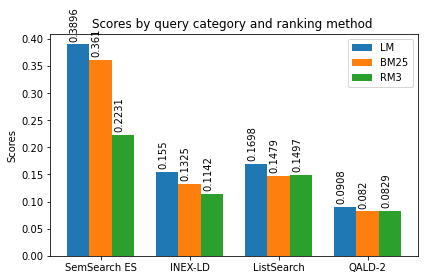

In [191]:
labels = ['SemSearch ES', 'INEX-LD', 'ListSearch', 'QALD-2']

data = [result['MAP_lm'].values,
result['MAP_bm25'].values,
result['MAP_rm3'].values]
X = np.arange(4)

x = np.arange(len(labels))  # the label locations
x = x + 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(X + 0.00, data[0], width = 0.25, label='LM')
rects2 = ax.bar(X + 0.25, data[1], width = 0.25, label='BM25')
rects3 = ax.bar(X + 0.50, data[2], width = 0.25, label = 'LM + RM3')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by query category and ranking method ')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 3, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    rotation=90,
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


fig.tight_layout()

plt.show()
